<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification

fatal: destination path 'Vietnamese-Review-Classification' already exists and is not an empty directory.
/content/Vietnamese-Review-Classification


In [3]:
!sudo apt-get install python3.7
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz --upgrade

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support
  python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7
  python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minima

In [6]:
!git pull origin master

remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (6/6), 719 bytes | 359.00 KiB/s, done.
From https://github.com/Akechi1412/Vietnamese-Review-Classification
 * branch            master     -> FETCH_HEAD
   8996f5b..20c8b64  master     -> origin/master
Updating 8996f5b..20c8b64
Fast-forward
 utils/data_preparing.py | 4 +++-
 1 file changed, 3 insertions(+), 1 deletion(-)


Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


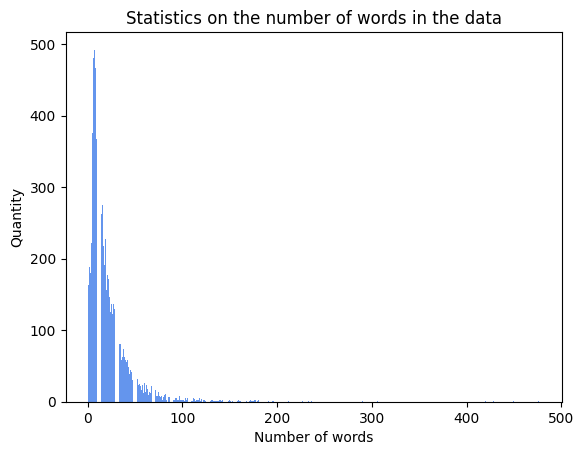

In [7]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

In [8]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/6, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

ValueError: Found input variables with inconsistent numbers of samples: [9000, 9003]